# Imports

In [1]:
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from numpy import amax, argmax, array
from pandas import read_csv, set_option, DatetimeIndex
from collections import deque
from scipy.special import expit
from random import random, randrange

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 3 
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = load_model("models/" + model_name) if is_eval else self._model()

    def _model(self):
        
        model = Sequential()
        model.add(Dense(128, kernel_regularizer=l2(1e-5), input_dim=self.state_size, activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(128, kernel_regularizer=l2(1e-5), activation="relu"))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())

        model.add(Dense(128, kernel_regularizer=l2(1e-5), activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(32, kernel_regularizer=l2(1e-5), activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(self.action_size, activation="linear"))
        
        opt = Adam(learning_rate=0.0001, decay=5e-5)
            
        model.compile(
        loss='mse',
        optimizer=opt,
        metrics=['accuracy']
          )
        
        #print(model.summary())
        
        return model

    def act(self, state):
        if not self.is_eval and random() <= self.epsilon:
            return randrange(self.action_size)
        
        options = self.model.predict(state, verbose=0)
        return argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        #progress(batch_size,l,"Loading")
        
        for state, action, reward, next_state, done in mini_batch:
            target = reward

            if not done:
                target = reward + self.gamma * amax(self.model.predict(next_state, verbose=0)[0])

            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 


In [3]:
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(expit(block[i + 1] - block[i]))

    return array([res])

def plot_behavior(data_input,states_buy,states_sell,profit):
   
    fig = plt.figure(figsize=(20,5))
    plt.plot(data_input,color='b',lw=2.)
    plt.plot(data_input,'^',markersize=10,color='g',label='Buying signal',markevery=states_buy)
    plt.plot(data_input,'v',markersize=10,color='r',label='Selling signal',markevery=states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.grid(True)
    plt.legend()
    return fig

# Obtendo os dados

In [4]:
window_size = 5
episode_count= 10
df = read_csv('candles_1D.csv') 

In [5]:
df

,from,to,open,close,min,max,date
0,1662395640,1662395700,0.993075,0.993135,0.993065,0.993155,2022-Sep-05 13:34
1,1662395700,1662395760,0.993145,0.993125,0.993055,0.993145,2022-Sep-05 13:35
2,1662395760,1662395820,0.993115,0.993165,0.993085,0.993185,2022-Sep-05 13:36
3,1662395820,1662395880,0.993165,0.993205,0.993135,0.993285,2022-Sep-05 13:37
4,1662395880,1662395940,0.993215,0.993225,0.993155,0.993275,2022-Sep-05 13:38
...,...,...,...,...,...,...,...
1436,1662481800,1662481860,0.991065,0.991045,0.991035,0.991275,2022-Sep-06 13:30
1437,1662481860,1662481920,0.991055,0.991105,0.991025,0.991255,2022-Sep-06 13:31
1438,1662481920,1662481980,0.991095,0.990995,0.990925,0.991225,2022-Sep-06 13:32
1439,1662481980,1662482040,0.990995,0.990835,0.990755,0.991055,2022-Sep-06 13:33


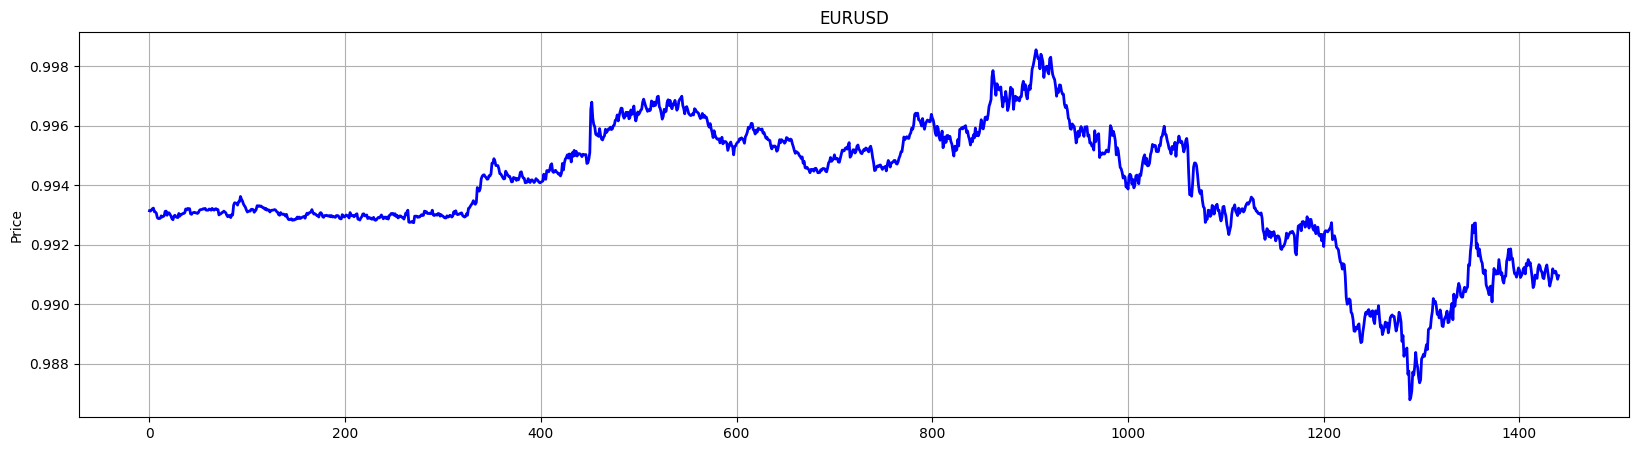

In [6]:
plt.figure(figsize=(20,5))
plt.plot(df['close'],color='b',lw=2.)
plt.ylabel("Price")
plt.title('EURUSD')
plt.grid(True)
plt.show();

Criando o modelo e treinando

Episode 0/10
--------------------------------
Total Profit: 0.00015
--------------------------------


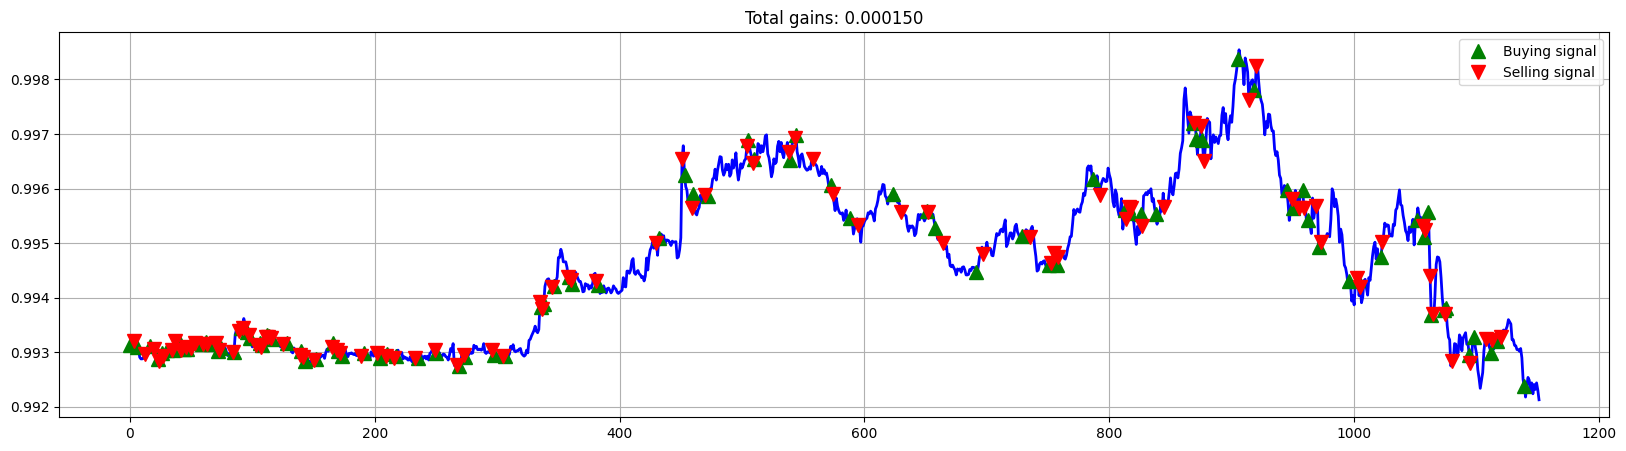

INFO:tensorflow:Assets written to: models/model_ep0\assets
Episode 1/10
--------------------------------
Total Profit: -0.001
--------------------------------


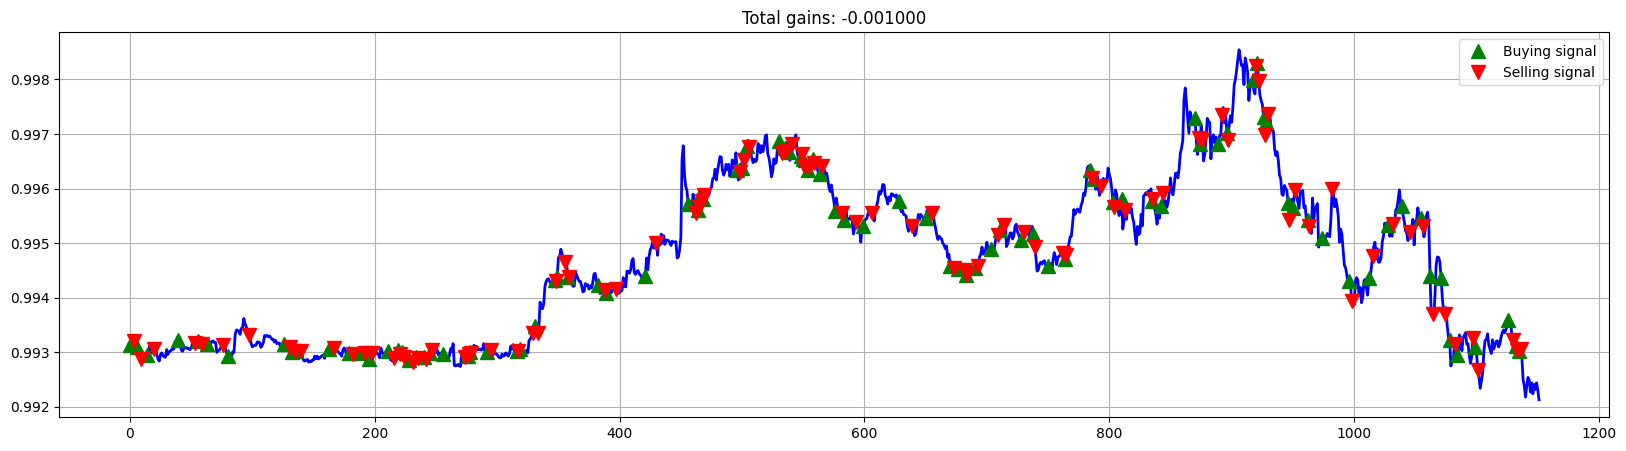

Episode 2/10
--------------------------------
Total Profit: 0.00496
--------------------------------


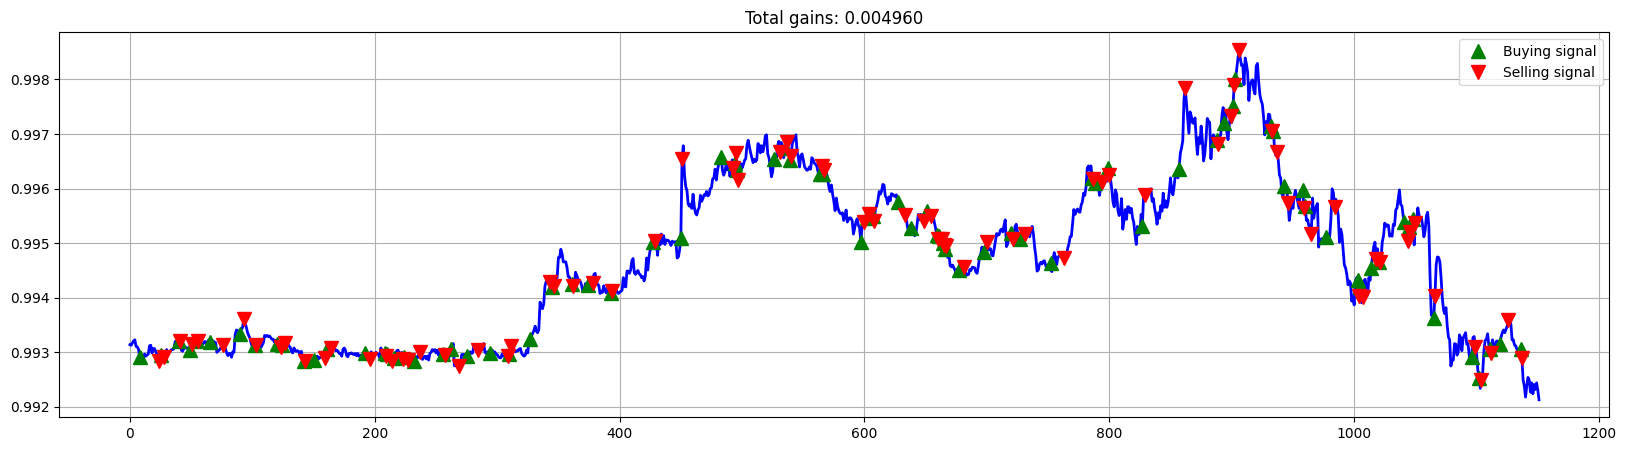

INFO:tensorflow:Assets written to: models/model_ep2\assets
Episode 3/10
--------------------------------
Total Profit: -0.00023
--------------------------------


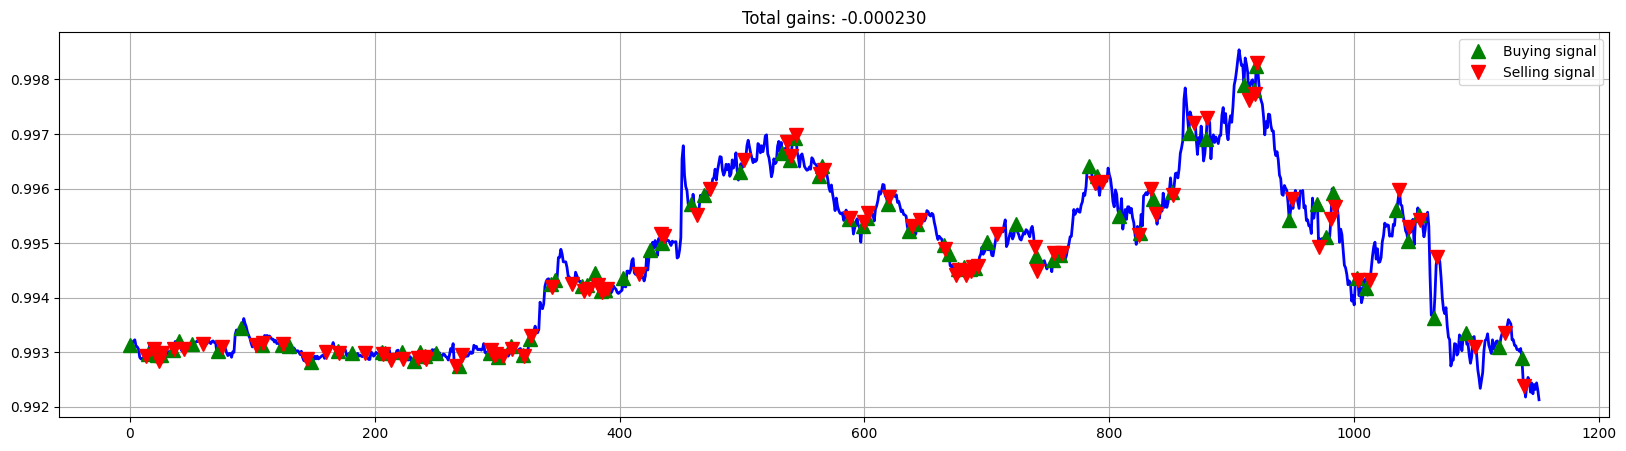

Episode 4/10
--------------------------------
Total Profit: 0.00046
--------------------------------


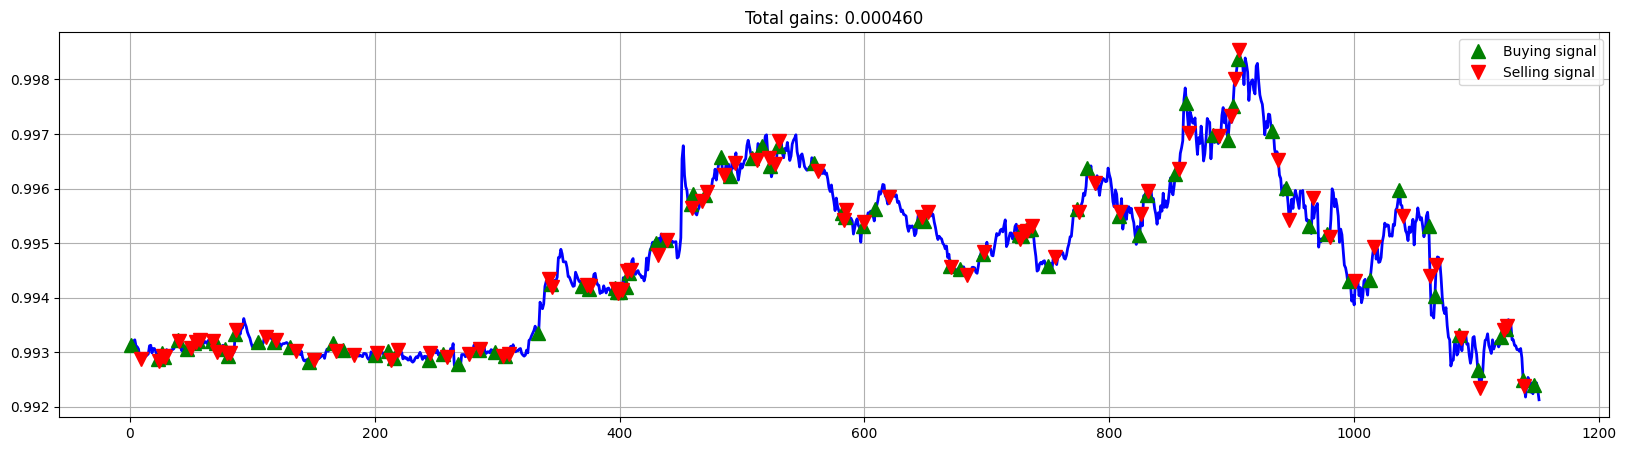

INFO:tensorflow:Assets written to: models/model_ep4\assets
Episode 5/10
--------------------------------
Total Profit: 0.00262
--------------------------------


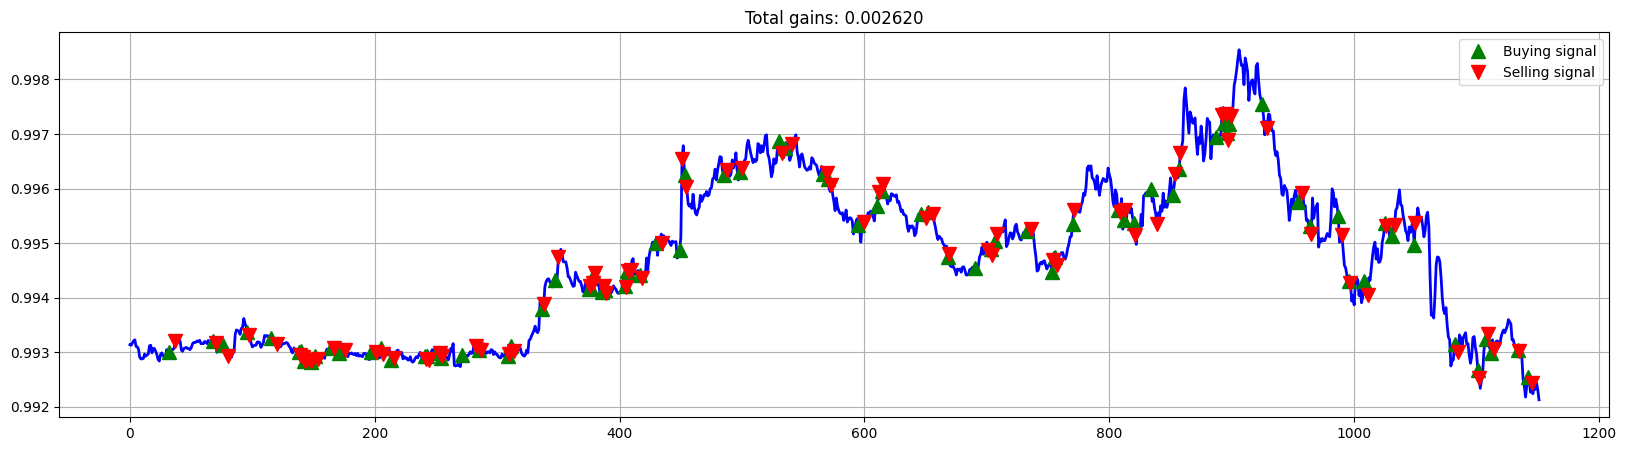

Episode 6/10
--------------------------------
Total Profit: 0.0012
--------------------------------


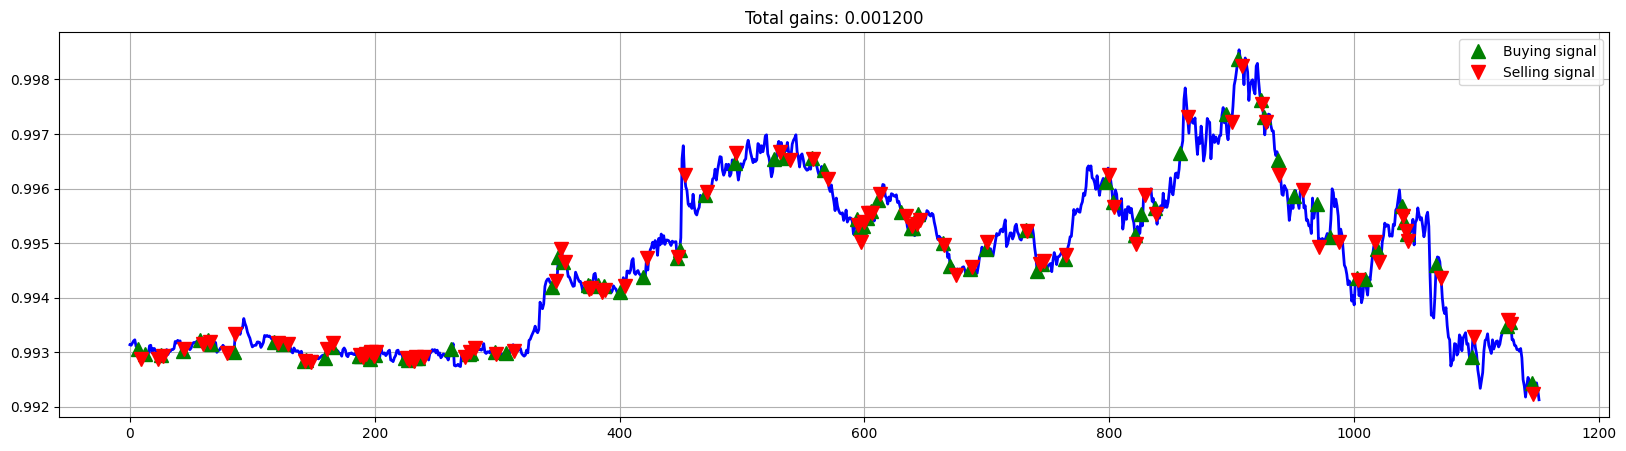

INFO:tensorflow:Assets written to: models/model_ep6\assets
Episode 7/10
--------------------------------
Total Profit: -0.0042
--------------------------------


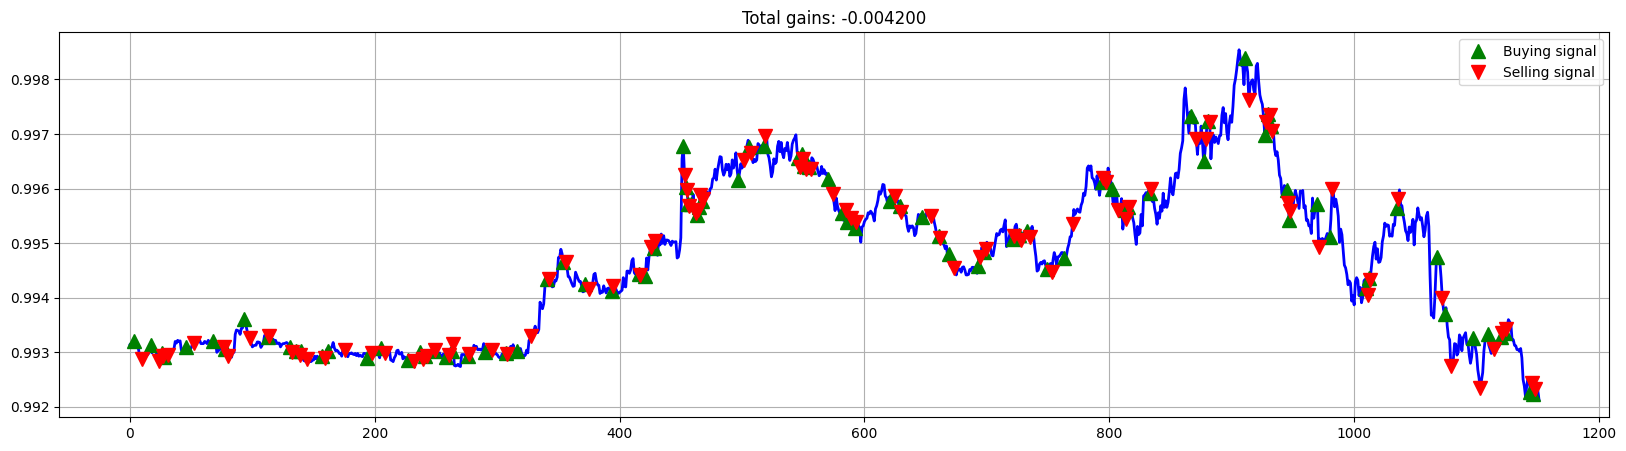

Episode 8/10
--------------------------------
Total Profit: 0.00154
--------------------------------


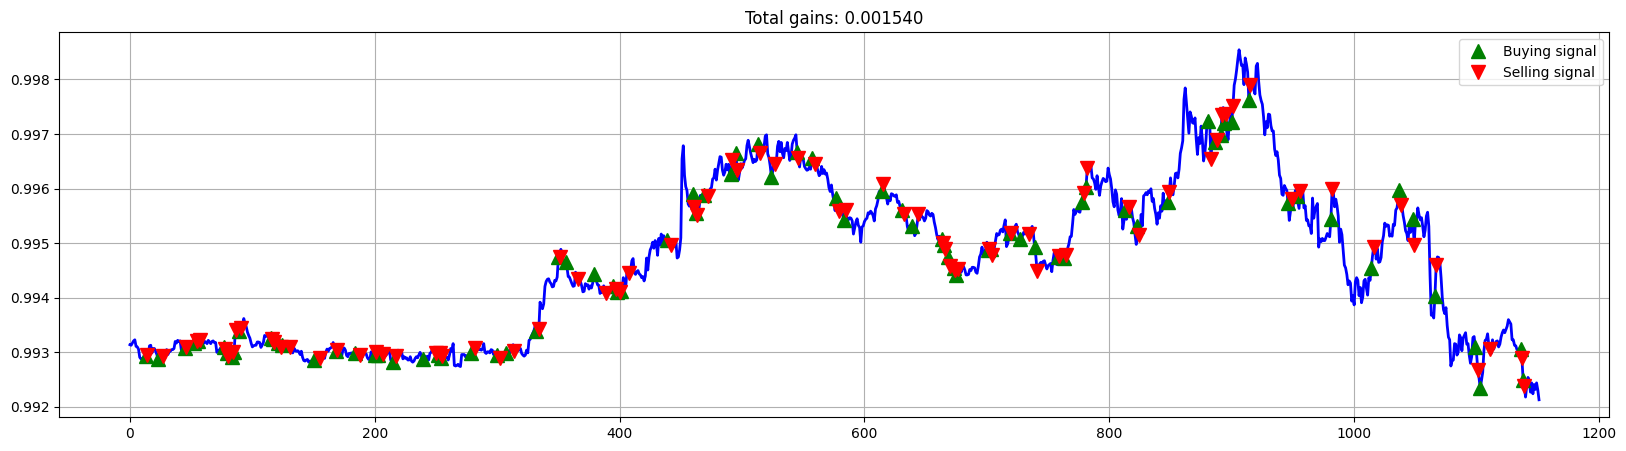

INFO:tensorflow:Assets written to: models/model_ep8\assets
Episode 9/10
--------------------------------
Total Profit: -0.00173
--------------------------------


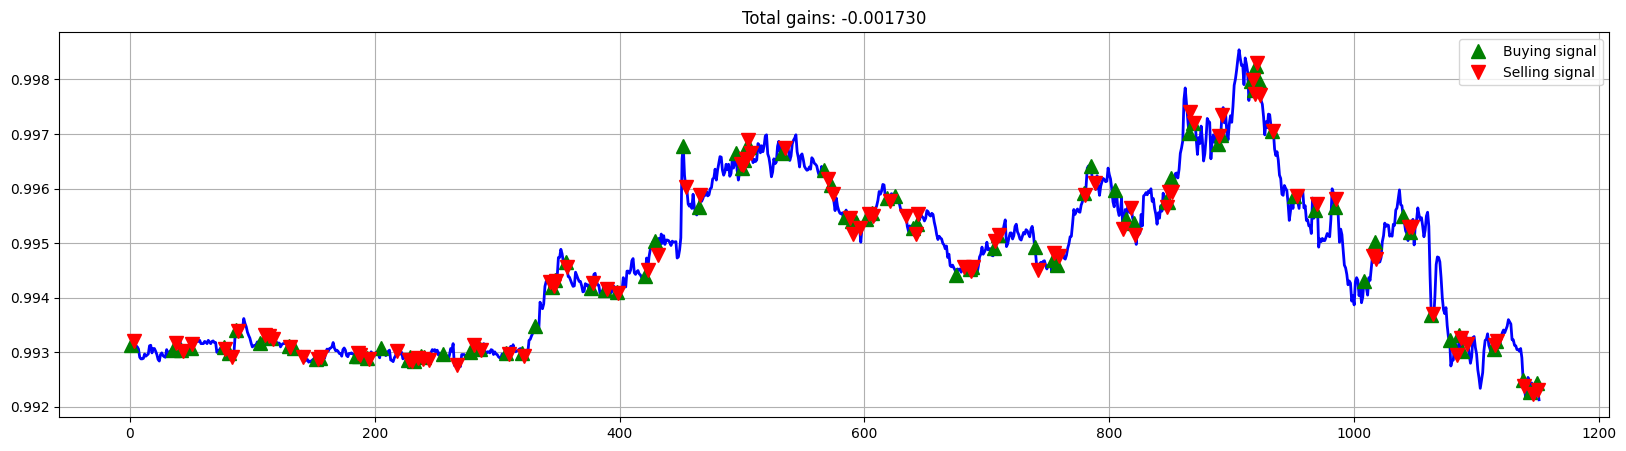

Episode 10/10
--------------------------------
Total Profit: 0.00393
--------------------------------


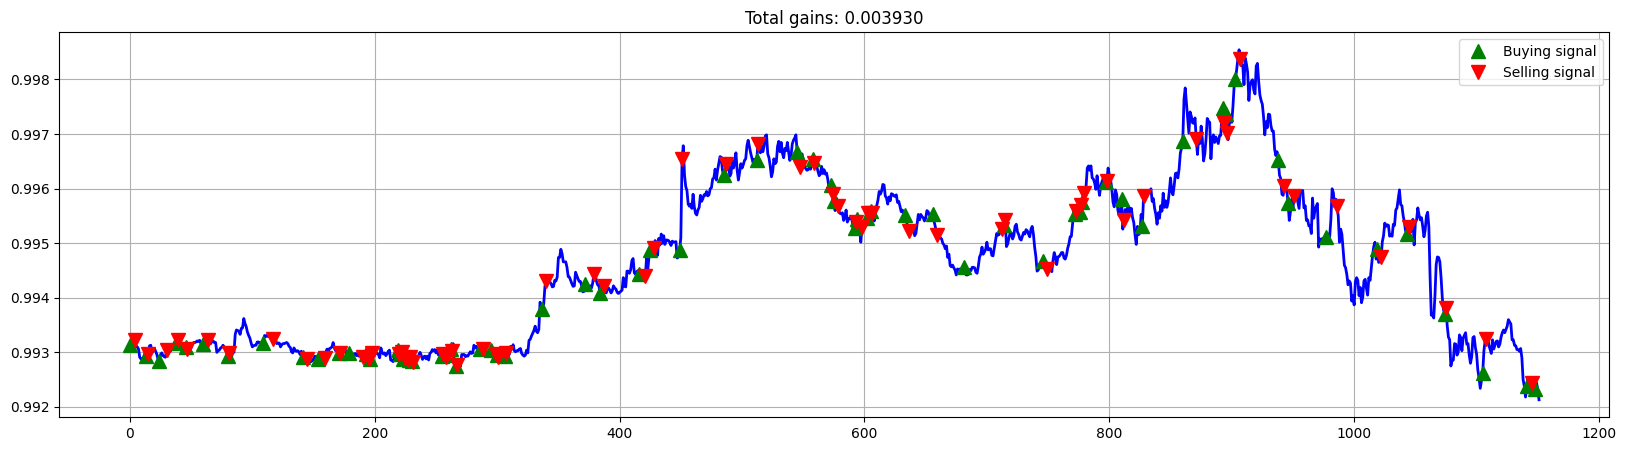

INFO:tensorflow:Assets written to: models/model_ep10\assets


In [7]:
agent = Agent(window_size)

set_option('display.width', 100)
set_option('display.precision', 3)
df.isnull().values.any()
df=df.fillna(method='ffill')

X=list(df['close'])

X=[float(x) for x in X]

validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

data = X_train
l = len(data) - 1
batch_size = 32


for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)
    
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        
        if action == 0: #hold
            #print(" Hold... "+str(data[t]))
            pass

        elif action == 1 and len(agent.inventory) == 0: #buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print(" Buy: " + str(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            agent.inventory.clear()
            #print(" Sell: " + str(data[t]) + " | Profit: " + str(data[t] - bought_price) + "| Reward: " + str(round(reward,6)))

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + str(round(total_profit,6)))
            print("--------------------------------")
            fig = plot_behavior(data,states_buy, states_sell, total_profit)
            plt.show();

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    if e % 2 == 0:
        agent.model.save("models/model_ep" + str(e))

In [8]:
%load_ext watermark

%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Thu Oct 06 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: not installed
aeppl : not installed

matplotlib: 3.5.3
sys       : 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]

Watermark: 2.3.1

